## Варіант 16
### Полiномiальна регресiя, алгоритм градiєнтного спуску за мiнi-батчами,MSE з регуляризацiєю за нормою L1.

In [1]:
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.compat.v1.disable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

#### Створюємо клас для генерації та переключення між обома датасетами

In [3]:
class Dataset():
    def __init__(self, dataset):
        if dataset == "1":
            self.first_dataset(200, 1, 1)
        elif dataset == "2":
            self.second_dataset()
            
    def first_dataset(self, N=200, err=1, rseed=1):
        rng = np.random.RandomState(rseed)
        self.X = rng.rand(N,1)**2
        self.y = (10 - 1 / (self.X.ravel() + 0.1))
        if err > 0:
            self.y += err * rng.randn(N)

        
    def second_dataset(self):
        X = load_diabetes().data
        self.y = load_diabetes().target
        X_normalized = StandardScaler().fit_transform(X)
        self.X = pd.DataFrame(X_normalized, columns=load_diabetes().feature_names)

#### Зображуємо дані графічно

Text(0, 0.5, 'y')

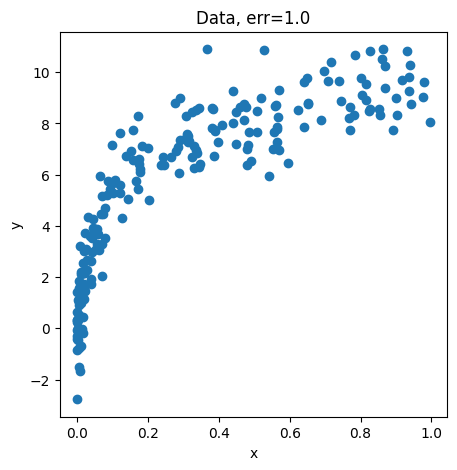

In [4]:
ds = Dataset('1')
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('Data, err=1.0')
ax.scatter(ds.X, ds.y)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [5]:
ds = Dataset("2")
ds.X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.800500,1.065488,1.297088,0.459841,-0.929746,-0.732065,-0.912451,-0.054499,0.418531,-0.370989
1,-0.039567,-0.938537,-1.082180,-0.553505,-0.177624,-0.402886,1.564414,-0.830301,-1.436589,-1.938479
2,1.793307,1.065488,0.934533,-0.119214,-0.958674,-0.718897,-0.680245,-0.054499,0.060156,-0.545154
3,-1.872441,-0.938537,-0.243771,-0.770650,0.256292,0.525397,-0.757647,0.721302,0.476983,-0.196823
4,0.113172,-0.938537,-0.764944,0.459841,0.082726,0.327890,0.171178,-0.054499,-0.672502,-0.980568


<AxesSubplot: >

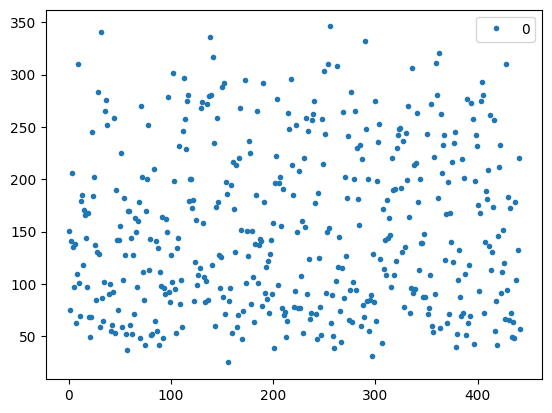

In [7]:
y = pd.DataFrame(ds.y)
y.plot(style='.')

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sex'}>,
        <AxesSubplot: title={'center': 'bmi'}>,
        <AxesSubplot: title={'center': 'bp'}>,
        <AxesSubplot: title={'center': 's1'}>],
       [<AxesSubplot: title={'center': 's2'}>,
        <AxesSubplot: title={'center': 's3'}>,
        <AxesSubplot: title={'center': 's4'}>,
        <AxesSubplot: title={'center': 's5'}>,
        <AxesSubplot: title={'center': 's6'}>]], dtype=object)

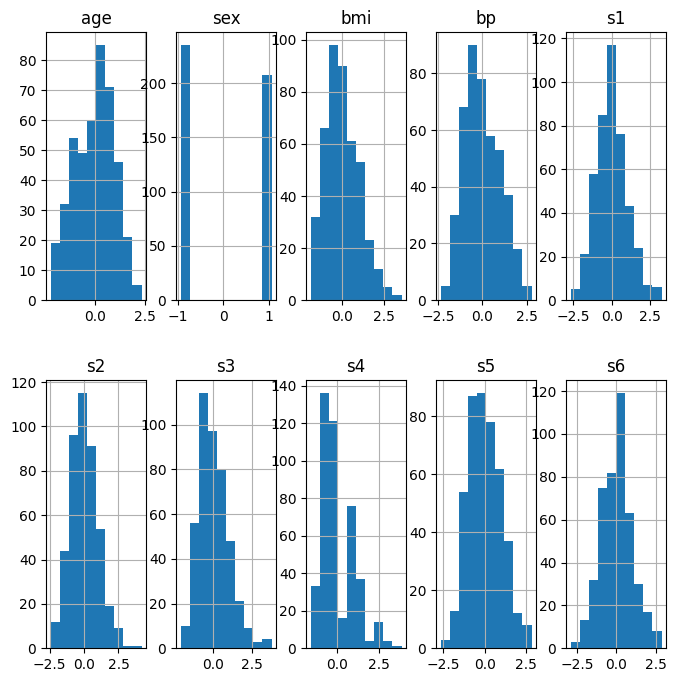

In [8]:
fig, axis = plt.subplots(2,5,figsize=(8, 8))
ds.X.hist(ax=axis)

#### Створюємо функцію поліноміальної регресії

In [57]:
def model(X, y, num_coef=2, num_epochs=1000, batch_size=8, learning_rate=0.01):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define the number of features for polynomial regression
    num_features = X_train.shape[1]
    
    # Define the placeholders for the input and output data
    X_placeholder = tf.placeholder(tf.float32, shape=[None, num_features*num_coef])
    y_placeholder = tf.placeholder(tf.float32, shape=[None, 1])

    # Define the variables for the polynomial regression model
    W = tf.Variable(tf.random_normal([num_features*num_coef, 1], dtype=tf.float32))
    b = tf.Variable(tf.zeros([1], dtype=tf.float32))

    # Calculate the polynomial features for the input data
    poly_features_train = np.hstack([np.power(X_train, i) for i in range(1, num_coef+1)])
    poly_features_test = np.hstack([np.power(X_test, i) for i in range(1, num_coef+1)])

    # Reshape the polynomial features to ensure the correct input shape
    poly_features_train = poly_features_train.reshape(X_train.shape[0], -1)
    poly_features_test = poly_features_test.reshape(X_test.shape[0], -1)

    # Define the regularization parameter for L1 regularization
    l1_reg = 0.001

    # Define the TensorFlow operations for the polynomial regression model
    y_pred = tf.matmul(X_placeholder, W) + b
    regularization_loss = l1_reg * tf.reduce_sum(tf.abs(W))
    mse_loss = tf.reduce_mean(tf.square(y_pred - y_placeholder))
    total_loss = mse_loss + regularization_loss
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(total_loss)

    # Train the model on the training set
    num_batches = int(np.ceil(poly_features_train.shape[0] / batch_size))

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        print('_'*20)
        for epoch in range(num_epochs):
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx+1) * batch_size, poly_features_train.shape[0])
                X_batch = poly_features_train[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx].reshape(-1, 1)
                _, loss = sess.run([train_op, total_loss], feed_dict={X_placeholder: X_batch, y_placeholder: y_batch})
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.2f}")
    
        # Evaluate the model on the test set
        train_loss = sess.run(total_loss, feed_dict={X_placeholder: poly_features_train, y_placeholder: y_train.reshape(-1, 1)})
        test_loss, test_mse = sess.run([total_loss, mse_loss], feed_dict={X_placeholder: poly_features_test, y_placeholder: y_test.reshape(-1, 1)})
        print(f"Test loss: {test_loss:.2f}, Test MSE: {test_mse:.2f}")
    
        y_pred_test = sess.run(y_pred, feed_dict={X_placeholder: poly_features_test})

    return X_test, y_test, y_pred_test, train_loss, test_loss

#### Створюємо функцію для пошуку найкращих параметрів

In [59]:
def best_params(X, y, param_grid):
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    import numpy as np
    import random

    # Perform grid search
    best_loss = float('inf')
    best_params = {}

    for num_coef in param_grid['num_coef']:
        for num_epochs in param_grid['num_epochs']:
            for batch_size in param_grid['batch_size']:
                for learning_rate in param_grid['learning_rate']:
                    X_test, y_test, y_pred_test, train_loss, test_loss = model(X, y, num_coef=num_coef, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate)
                    if test_loss < best_loss:
                        best_loss = test_loss
                        best_params = {'num_coef': num_coef, 'num_epochs': num_epochs, 'batch_size': batch_size, 'learning_rate': learning_rate}
    
    print(f"Best loss: {best_loss:.2f}")
    print(f"Best parameters: {best_params}")

    # Define the parameter distributions for random search
    param_space = {
        'num_coef': np.arange(best_params['num_coef'] - 1, best_params['num_coef'] + 2),
        'num_epochs': np.arange(best_params['num_epochs'] - 250, best_params['num_epochs'] + 251, 250),
        'batch_size': np.arange(best_params['batch_size'] - 2, best_params['batch_size'] + 3, 2),
        'learning_rate': np.linspace(best_params['learning_rate'] - 0.005, best_params['learning_rate'] + 0.005, 5)
    }
    
    # Define the number of trials to run
    num_trials = 3

    # Initialize the best test loss and best parameters
    best_test_loss = float('inf')

    # Run the hyperparameter search
    for i in range(num_trials):
        # Sample random hyperparameters
        params = {k: random.choice(v) for k, v in param_space.items()}

        # Train the model with the sampled hyperparameters
        _, _, _, train_loss, test_loss = model(X, y, **params)

        # Print the current results
        print(f'Trial {i+1}: Test loss: {test_loss:.2f}, Params: {params}')

        # Update the best test loss and best parameters
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_params = params

    # Print the final best results
    print(f'Best test loss: {best_test_loss:.2f}, Best params: {best_params}')

#### Працюємо з першим датасетом

In [61]:
ds=Dataset("1")

param_grid = {
        'num_coef': [2, 4],
        'num_epochs': [300, 500, 1000],
        'batch_size': [4, 8, 16],
        'learning_rate': [0.01, 0.05]
    }


best_params(ds.X, ds.y, param_grid)

____________________
Epoch 0, Loss: 17.40
Epoch 100, Loss: 4.95
Epoch 200, Loss: 4.35
Test loss: 2.12, Test MSE: 2.09
____________________
Epoch 0, Loss: 7.91
Epoch 100, Loss: 3.47
Epoch 200, Loss: 3.07
Test loss: 1.47, Test MSE: 1.43
____________________
Epoch 0, Loss: 24.73
Epoch 100, Loss: 9.44
Epoch 200, Loss: 8.65
Test loss: 2.77, Test MSE: 2.76
____________________
Epoch 0, Loss: 14.68
Epoch 100, Loss: 6.92
Epoch 200, Loss: 5.72
Test loss: 1.53, Test MSE: 1.50
____________________
Epoch 0, Loss: 33.11
Epoch 100, Loss: 7.41
Epoch 200, Loss: 6.95
Test loss: 3.46, Test MSE: 3.45
____________________
Epoch 0, Loss: 18.47
Epoch 100, Loss: 5.84
Epoch 200, Loss: 4.86
Test loss: 1.89, Test MSE: 1.86
____________________
Epoch 0, Loss: 16.94
Epoch 100, Loss: 4.79
Epoch 200, Loss: 4.24
Epoch 300, Loss: 3.87
Epoch 400, Loss: 3.62
Test loss: 1.69, Test MSE: 1.66
____________________
Epoch 0, Loss: 7.98
Epoch 100, Loss: 3.40
Epoch 200, Loss: 3.05
Epoch 300, Loss: 2.98
Epoch 400, Loss: 2.96
Te

In [62]:
X_test, y_test, predictions, train_loss, test_loss = model(ds.X, ds.y, num_coef=3, 
                                                           num_epochs=1000, batch_size=2, learning_rate=0.0475)

____________________
Epoch 0, Loss: 5.18
Epoch 100, Loss: 4.11
Epoch 200, Loss: 4.03
Epoch 300, Loss: 3.97
Epoch 400, Loss: 3.93
Epoch 500, Loss: 3.91
Epoch 600, Loss: 3.89
Epoch 700, Loss: 3.89
Epoch 800, Loss: 3.89
Epoch 900, Loss: 3.89
Test loss: 1.20, Test MSE: 1.11


Text(0, 0.5, 'y')

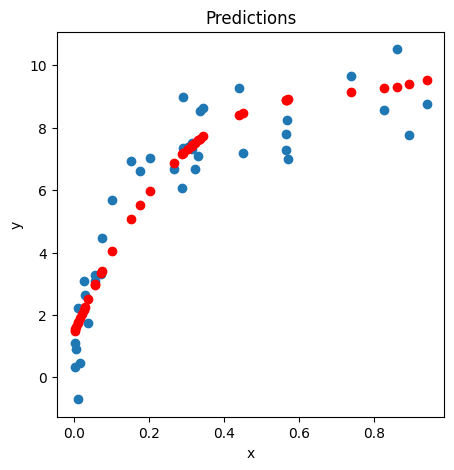

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.set_title('Predictions',)
ax.scatter(X_test, y_test)
ax.scatter(X_test, predictions, c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')

#### Працюємо з другим датасетом

In [67]:
ds=Dataset("2")
X_test, y_test, predictions, train_loss, test_loss = model(ds.X, ds.y, num_coef=2, 
                                                           num_epochs=2000, batch_size=8, learning_rate=0.05)

____________________
Epoch 0, Loss: 28038.36
Epoch 100, Loss: 21659.22
Epoch 200, Loss: 21675.76
Epoch 300, Loss: 21687.66
Epoch 400, Loss: 21696.18
Epoch 500, Loss: 21702.30
Epoch 600, Loss: 21706.73
Epoch 700, Loss: 21709.93
Epoch 800, Loss: 21712.25
Epoch 900, Loss: 21713.92
Epoch 1000, Loss: 21715.13
Epoch 1100, Loss: 21716.00
Epoch 1200, Loss: 21716.64
Epoch 1300, Loss: 21717.08
Epoch 1400, Loss: 21717.41
Epoch 1500, Loss: 21717.63
Epoch 1600, Loss: 21717.80
Epoch 1700, Loss: 21717.91
Epoch 1800, Loss: 21717.99
Epoch 1900, Loss: 21718.05
Test loss: 27672.46, Test MSE: 27672.02


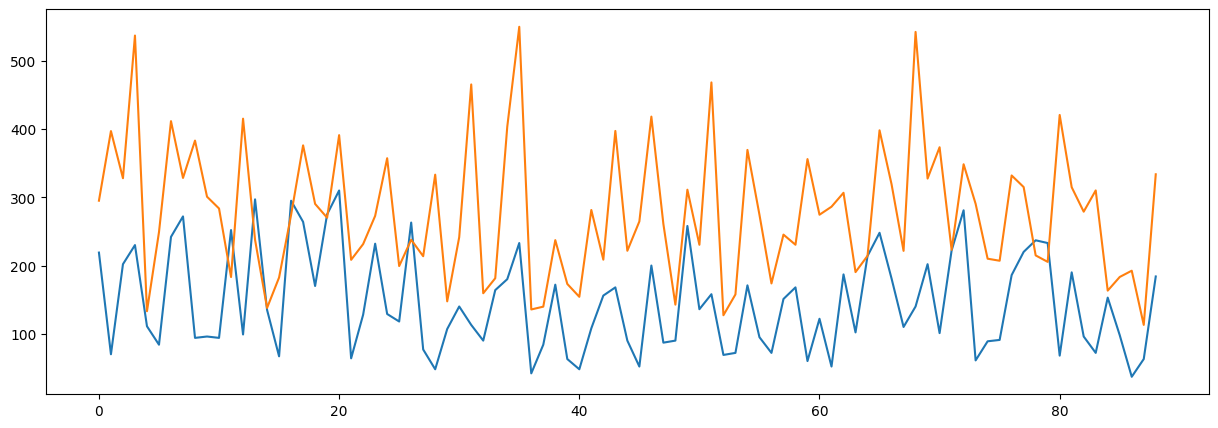

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(y_test)
plt.plot(predictions)
plt.show()